In [1]:
import torch
import time
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from Adam import Adam
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
import scipy.io
import pickle

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)

In [2]:
# normalization, Gaussian
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()
        
#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)
    
    
#Complex multiplication
def compl_mul3d(a, b):
    # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
    op = partial(torch.einsum, "bixyz,ioxyz->boxyz")
    return torch.stack([
        op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
        op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    ], dim=-1)

In [3]:
################################################################
# 3d fourier layers
################################################################

# class SpectralConv3d_fast(nn.Module):
#     def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
#         super(SpectralConv3d_fast, self).__init__()

#         """
#         3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
#         """

#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
#         self.modes2 = modes2
#         self.modes3 = modes3

#         self.scale = (1 / (in_channels * out_channels))
#         self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))
#         self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))
#         self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))
#         self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))

#     def forward(self, x):
#         batchsize = x.shape[0]
#         #Compute Fourier coeffcients up to factor of e^(- something constant)
#         x_ft = torch.fft.rfft(x, 3)

#         # Multiply relevant Fourier modes
#         out_ft = torch.zeros(batchsize, self.in_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, 2, device=x.device)
#         out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] =             compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
#         out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] =             compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
#         out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] =             compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
#         out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] =             compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

#         #Return to physical space
#         x = torch.fft.irfft(out_ft, 3, signal_sizes=(x.size(-3), x.size(-2), x.size(-1)))
#         return x

class SpectralConv3d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d_fast, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

class SimpleBlock3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(SimpleBlock3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        input shape: (batchsize, x=64, y=64, t=40, c=13)
        output: the solution of the next 40 timesteps
        output shape: (batchsize, x=64, y=64, t=40, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: gridt, source, velocity

        self.conv0 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y, size_z = x.shape[1], x.shape[2], x.shape[3]
        
        x = self.fc0(x)
        # print('input shape before rearrangement:', x.shape)
        x = x.permute(0, 4, 1, 2, 3)
        # print('input shape after rearrangement:', x.shape)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        # print('output shape of the first block:', x1.shape, x2.shape)
        x = self.bn0(x1 + x2)
        x = F.relu(x)
        
        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = self.bn1(x1 + x2)
        x = F.relu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = self.bn2(x1 + x2)
        x = F.relu(x)
        
        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = self.bn3(x1 + x2)


        x = x.permute(0, 2, 3, 4, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

class Net3d(nn.Module):
    def __init__(self, modes, width):
        super(Net3d, self).__init__()

        """
        A wrapper function
        """

        self.conv1 = SimpleBlock3d(modes, modes, modes, width)


    def forward(self, x):
        x = self.conv1(x)
        return x.squeeze()


    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

In [4]:
vel_model_0 = np.load('/home/g202321530/Yang/Data/Open_FWI/Data/Style_Family/Style_A/model58.npy')
v = vel_model_0[200, 0, :, :]/1000

# Gnerate random source location
source_num = 50
columns = 2

min_val = 1  # Minimum value (inclusive)
max_val = v.shape[0]  # Maximum value (inclusive)
np.random.seed(202404)
source_loc = (np.random.randint(min_val, max_val + 1, size=(source_num, columns))*10).astype(float)
print(v.shape, source_loc)

(70, 70) [[190.  20.]
 [340. 390.]
 [590. 490.]
 [ 10. 600.]
 [110. 460.]
 [320. 100.]
 [670. 490.]
 [590.  20.]
 [540. 500.]
 [560. 660.]
 [450. 530.]
 [360. 660.]
 [560. 670.]
 [550.  20.]
 [550. 650.]
 [ 50.  10.]
 [610. 380.]
 [240. 210.]
 [240. 200.]
 [570. 320.]
 [230. 620.]
 [240.  10.]
 [560. 310.]
 [540. 150.]
 [500. 180.]
 [ 80. 220.]
 [240. 600.]
 [670. 330.]
 [170.  40.]
 [120. 290.]
 [150. 700.]
 [400. 280.]
 [260. 380.]
 [ 20. 540.]
 [110. 190.]
 [350. 640.]
 [490. 550.]
 [310. 250.]
 [150. 600.]
 [580. 310.]
 [ 60. 640.]
 [590. 190.]
 [560. 640.]
 [440. 550.]
 [ 50. 420.]
 [370. 620.]
 [190. 100.]
 [200. 510.]
 [110. 460.]
 [ 80. 260.]]


In [5]:
################################################################
# Input
################################################################

ntrain = 40
ntest = 10

modes = 24
width = 48 

batch_size = 1

epochs = 1000
learning_rate = 1e-3
scheduler_step = 25
scheduler_gamma = 0.5
freq = 3

print(epochs, learning_rate, scheduler_step, scheduler_gamma)

path = 'N'+str(ntrain)+'_ep' + str(epochs) + '_m' + str(
    modes)+ '_w' + str(width)+'_lr'+str(learning_rate)+'_batch'+str(batch_size)+'_freq'+str(freq)


runtime = np.zeros(2, )
t1 = default_timer()

sub = 1
S = 70 // sub
T_in = 2
T = 100 


srcxy = source_loc
# dV = np.load('input_a/dV.npy')
vel_model_0 = np.load('/home/g202321530/Yang/Data/Open_FWI/Data/Style_Family/Style_A/model58.npy')
dV = vel_model_0[200, 0, :, :]/1000
print('srcxy shape and dV shape:', srcxy.shape, dV.shape)
nx, ny = 70, 70
x = np.linspace(-5e3, 5e3, nx)
y = np.linspace(-5e3, 5e3, ny)
print('shape of x and y:', x.shape, y.shape)

xx, yy = np.meshgrid(x, y, indexing="ij")

print('shape of xx and yy:', xx.shape, yy.shape)

# vp = 3000.0 * np.ones_like(xx)

src_Frequency = 3
src_Velocity = 3000
src_width = (1 / src_Frequency * src_Velocity)

train_a = np.zeros((ntrain, S, S, T_in))
train_u = np.zeros((ntrain, S, S, T))

test_a = np.zeros((ntest, S, S, T_in))
test_u = np.zeros((ntest, S, S, T))


# train_a[:,:,:,0] =  vp + (vp * (dV[:ntrain,:,:] / 100))
for i in range(ntrain):
    train_a[i,:,:,1] = v*np.exp(-(xx - srcxy[i, 0])** 2 / src_width ** 2
                  ) * np.exp(-(yy - srcxy[i,1])** 2 / src_width ** 2)  
    # train_u[i,:,:,:] = np.load('input_u/No'+str(i)+'.npy')

offset_test = ntrain
# test_a[:,:,:,0] =  vp + (vp * (dV[offset_test:offset_test+ntest,:,:] / 100))
for i in range(ntest):
    test_a[i,:,:,1] = v*np.exp(-(xx - srcxy[offset_test+i, 0])** 2 / src_width ** 2
                  ) * np.exp(-(yy - srcxy[offset_test+i,1])** 2 / src_width ** 2)
    # test_u[i,:,:,:] = np.load('input_u/No'+str(offset_test+i)+'.npy')


wavefield = np.load('/home/g202321530/Yang/Data/Open_FWI/Code/training_data/Train_58_f_3.0Hz_nbl_50_source_num_50.npy')
wavefield = np.transpose(wavefield, [0, 2, 3, 1])
wavefield = wavefield[:, 20:90, 20:90, :]
print('size of wavefield:', wavefield.shape)

train_u = wavefield[:ntrain, :, :, :]
test_u = wavefield[ntrain:, :, :, :]

train_a = torch.from_numpy(train_a.astype(np.float32))
train_u = torch.from_numpy(train_u.astype(np.float32))
test_a = torch.from_numpy(test_a.astype(np.float32))
test_u = torch.from_numpy(test_u.astype(np.float32))
print(f'shape of train_a:{train_a.shape}\tshape of test_a:{test_a.shape}\nshape of train_u:{train_u.shape}\tshape of test_u:{test_u.shape}')
# print(train_a.shape)
# print(test_a.shape)
# print(train_u.shape)
# print(test_u.shape)
assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])


# Standarization:
a_normalizer = GaussianNormalizer(train_a)
y_normalizer = GaussianNormalizer(train_u)

# Saving pickles:
pickle_out = open('pickle/'+path+'_a_normalizer.pickle', "wb")
pickle.dump(a_normalizer, pickle_out)
pickle_out.close()
pickle_out = open('pickle/'+path+'_y_normalizer.pickle', "wb")
pickle.dump(y_normalizer, pickle_out)
pickle_out.close()


train_a = a_normalizer.encode(train_a)

test_a = a_normalizer.encode(test_a)


train_a = train_a.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
test_a = test_a.reshape(ntest,S,S,1,T_in).repeat([1,1,1,T,1])


gridt = torch.tensor(np.linspace(0, 1, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, T, 1).repeat([1, S, S, 1, 1])


train_a = torch.cat((gridt.repeat([ntrain,1,1,1,1]), train_a), dim=-1)
test_a = torch.cat((gridt.repeat([ntest,1,1,1,1]), test_a), dim=-1)

train_mask = torch.ones_like(train_u)
test_mask = torch.ones_like(test_u)


# zero padding to make x,y periodic for fourier transform
S_pad = S//16 

print(train_a.shape)
train_a = F.pad(train_a, (0,0,0, 0, S_pad,S_pad,S_pad,S_pad,0,0))
print(train_a.shape)

print(test_a.shape)
test_a = F.pad(test_a, (0,0,0, 0, S_pad,S_pad,S_pad,S_pad,0,0))
print(test_a.shape)

print(train_u.shape)
train_u = F.pad(train_u, (0, 0, S_pad,S_pad,S_pad,S_pad,0,0))
print(train_u.shape)

print(test_u.shape)
test_u = F.pad(test_u, (0, 0, S_pad,S_pad,S_pad,S_pad,0,0))
print(test_u.shape)

print(train_mask.shape)
train_mask = F.pad(train_mask, (0, 0, S_pad,S_pad,S_pad,S_pad,0,0))
print(train_mask.shape)

print(test_mask.shape)
test_mask = F.pad(test_mask, (0, 0, S_pad,S_pad,S_pad,S_pad,0,0))
print(test_u.shape)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u, train_mask), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u, test_mask), batch_size=batch_size, shuffle=False)

t2 = default_timer()

print('preprocessing finished, time used:', t2-t1)

# print(srcxy)

1000 0.001 25 0.5
srcxy shape and dV shape: (50, 2) (70, 70)
shape of x and y: (70,) (70,)
shape of xx and yy: (70, 70) (70, 70)
size of wavefield: (50, 70, 70, 100)
shape of train_a:torch.Size([40, 70, 70, 2])	shape of test_a:torch.Size([10, 70, 70, 2])
shape of train_u:torch.Size([40, 70, 70, 100])	shape of test_u:torch.Size([10, 70, 70, 100])
torch.Size([40, 70, 70, 100, 3])
torch.Size([40, 78, 78, 100, 3])
torch.Size([10, 70, 70, 100, 3])
torch.Size([10, 78, 78, 100, 3])
torch.Size([40, 70, 70, 100])
torch.Size([40, 78, 78, 100])
torch.Size([10, 70, 70, 100])
torch.Size([10, 78, 78, 100])
torch.Size([40, 70, 70, 100])
torch.Size([40, 78, 78, 100])
torch.Size([10, 70, 70, 100])
torch.Size([10, 78, 78, 100])
preprocessing finished, time used: 0.20155626395717263


In [6]:
# plt.imshow(dV[1, :, :], cmap='jet')

In [7]:
################################################################
# training and evaluation
################################################################

# not parallel
device = torch.device('cuda:1')
model = Net3d(modes, width).to(device)
print(model.count_params())
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# # parallel
# device = torch.device('cuda:2')
# model = Net3d(modes, width).to(device)
# model = nn.DataParallel(model, device_ids = [2,3,4,6,7])
# print(model.module.count_params())
# optimizer = Adam(model.module.parameters(), lr=learning_rate, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

myloss = LpLoss(size_average=False)
# myloss = nn.MSE(size_average=False)

y_normalizer.cuda()

losstrain = np.zeros(epochs)
losstest = np.zeros(epochs)
train_loss = []
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    flag = 0
    for x, y, z in train_loader:
        x, y, z = x.to(device), y.to(device), z.to(device)

        optimizer.zero_grad()
        out = model(x)

        out = y_normalizer.decode(out)
        #---------------------     
        out = out.reshape(z.shape) * z
        #---------------------
        mse = F.mse_loss(out, y, reduction='mean')
        # mse.backward()

        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1)) 
        l2.backward()

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        
        flag+=1
       
    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y, z in test_loader:
            x, y, z = x.to(device), y.to(device), z.to(device)
            out = model(x)

            out = y_normalizer.decode(out)
            #--------------------- 
            out = out.reshape(z.shape) * z
            #---------------------
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

#     print(default_timer()-t1)
    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    train_loss.append(train_mse)
    t2 = default_timer()
    # print(ep, t2-t1, train_mse, train_l2, test_l2,flush=True)
    print(f"Epoch: {ep}/{epochs}, Train_mse: {train_mse}, Train_l2: {train_l2}, Test_l2: {test_l2}, Time: {t2-t1}", flush=True)
    losstrain[ep] = train_l2 *1
    losstest[ep] = test_l2 *1

torch.save(model, 'model/'+path)
np.savetxt('loss/'+path+'_train.txt', losstrain)
np.savetxt('loss/'+path+'_test.txt', losstest)

509624321
Epoch: 0/1000, Train_mse: 462.6360263824463, Train_l2: 0.9968020752072334, Test_l2: 0.9867409646511078, Time: 20.286492543062195
Epoch: 1/1000, Train_mse: 454.72668113708494, Train_l2: 0.9859884560108185, Test_l2: 0.981146240234375, Time: 19.036523894872516
Epoch: 2/1000, Train_mse: 450.03650054931643, Train_l2: 0.9818784609436989, Test_l2: 0.9764336824417115, Time: 18.88015831192024
Epoch: 3/1000, Train_mse: 441.6603584289551, Train_l2: 0.9699176162481308, Test_l2: 0.9615393996238708, Time: 18.72890195180662
Epoch: 4/1000, Train_mse: 422.2494945526123, Train_l2: 0.9506406933069229, Test_l2: 0.9334657967090607, Time: 18.76201567100361
Epoch: 5/1000, Train_mse: 407.9933734893799, Train_l2: 0.9373731732368469, Test_l2: 0.92870334982872, Time: 18.773138360120356
Epoch: 6/1000, Train_mse: 384.4182804107666, Train_l2: 0.9087478697299958, Test_l2: 0.892681336402893, Time: 18.78170294687152
Epoch: 7/1000, Train_mse: 353.8206016540527, Train_l2: 0.8730821222066879, Test_l2: 0.8665432

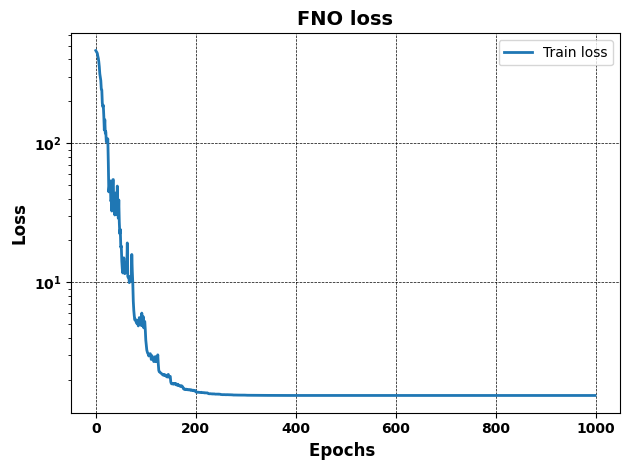

In [8]:
################################################################
# Plotting loss curve
################################################################
# print(len(train_mse))
plt.semilogy(train_loss, label="Train loss", linewidth=2) # Plots the total loss

plt.title("FNO loss", fontsize=14, fontweight='bold')   # Sets the title of the figure

plt.xlabel("Epochs ", fontsize=12, fontweight='bold')              # Sets the x-axis label of the figure
plt.ylabel("Loss", fontsize=12, fontweight='bold')                # Sets the y-axis label of the figure
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.grid(color = 'black', linestyle = '--', linewidth = 0.5) # Sets the grid of the figure

plt.legend(loc="upper right")   # Sets the legend of the figure

plt.tight_layout()
plt.savefig(f'./figs/modified/loss_curve/Loss_epoch_{epochs}_width_{width}_freq_{freq}Hz.pdf', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/modified/loss_curve/Loss_epoch_{epochs}_width_{width}_freq_{freq}Hz.png', bbox_inches="tight", dpi=300)

In [9]:
# Evaluation
pred = torch.zeros(test_u.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u, test_mask), batch_size=batch_size, shuffle=False)
with torch.no_grad():
    for x, y, z in test_loader:
        test_l2 = 0
        x, y, z = x.to(device), y.to(device), z.to(device)

        out = model(x)
        
        out = y_normalizer.decode(out)

        #---------------------     
        out = out.reshape(z.shape) * z
        #---------------------

        pred[index: index+out.shape[0]] = out


        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item() 
        print(index, test_l2)
        index = index + out.shape[0]
# %mkdir eval
np.save('eval/'+path+'_eval.npy', pred[:,S_pad:-S_pad,S_pad:-S_pad,:].cpu().numpy())

0 0.3241347372531891
1 0.4206017851829529
2 0.17477276921272278
3 0.23060062527656555
4 0.3787803649902344
5 0.2518366873264313
6 0.33567896485328674
7 0.27725106477737427
8 0.2236652821302414
9 0.3510466516017914


In [10]:
pre_data = pred[:,S_pad:-S_pad,S_pad:-S_pad,:].cpu().numpy()
print(pre_data.shape)

(10, 70, 70, 100)


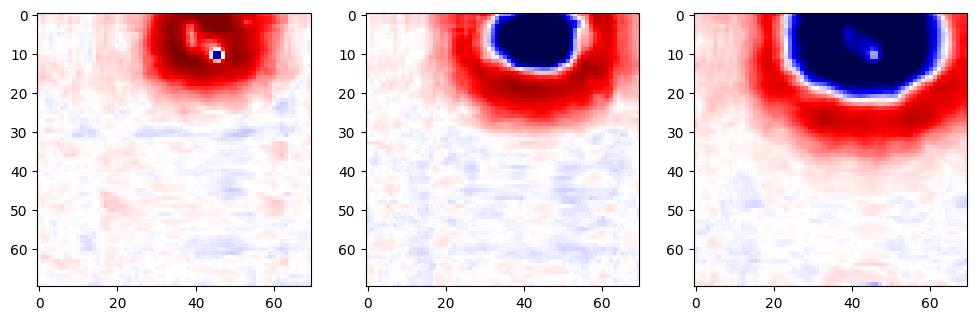

In [11]:
import matplotlib.pyplot as plt
n = 4
clip=60
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(pre_data[n, :, :, 39], aspect='1', cmap ='seismic_r', vmin = -clip, vmax =clip)

plt.subplot(132)
plt.imshow(pre_data[n, :, :, 49], aspect='1', cmap ='seismic_r', vmin = -clip, vmax =clip)

plt.subplot(133)
plt.imshow(pre_data[n, :, :, 59], aspect='1', cmap ='seismic_r', vmin = -clip, vmax =clip)
plt.savefig(f'./figs/modified_fno_acoustic_predict_smaple_{ntrain}_e{epochs}_smaple{n}_slice{40_50_60}.png', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/modified_fno_acoustic_predict_smaple_{ntrain}_e{epochs}_smaple{n}_slice{40_50_60}.pdf', bbox_inches="tight", dpi=300)
plt.show()

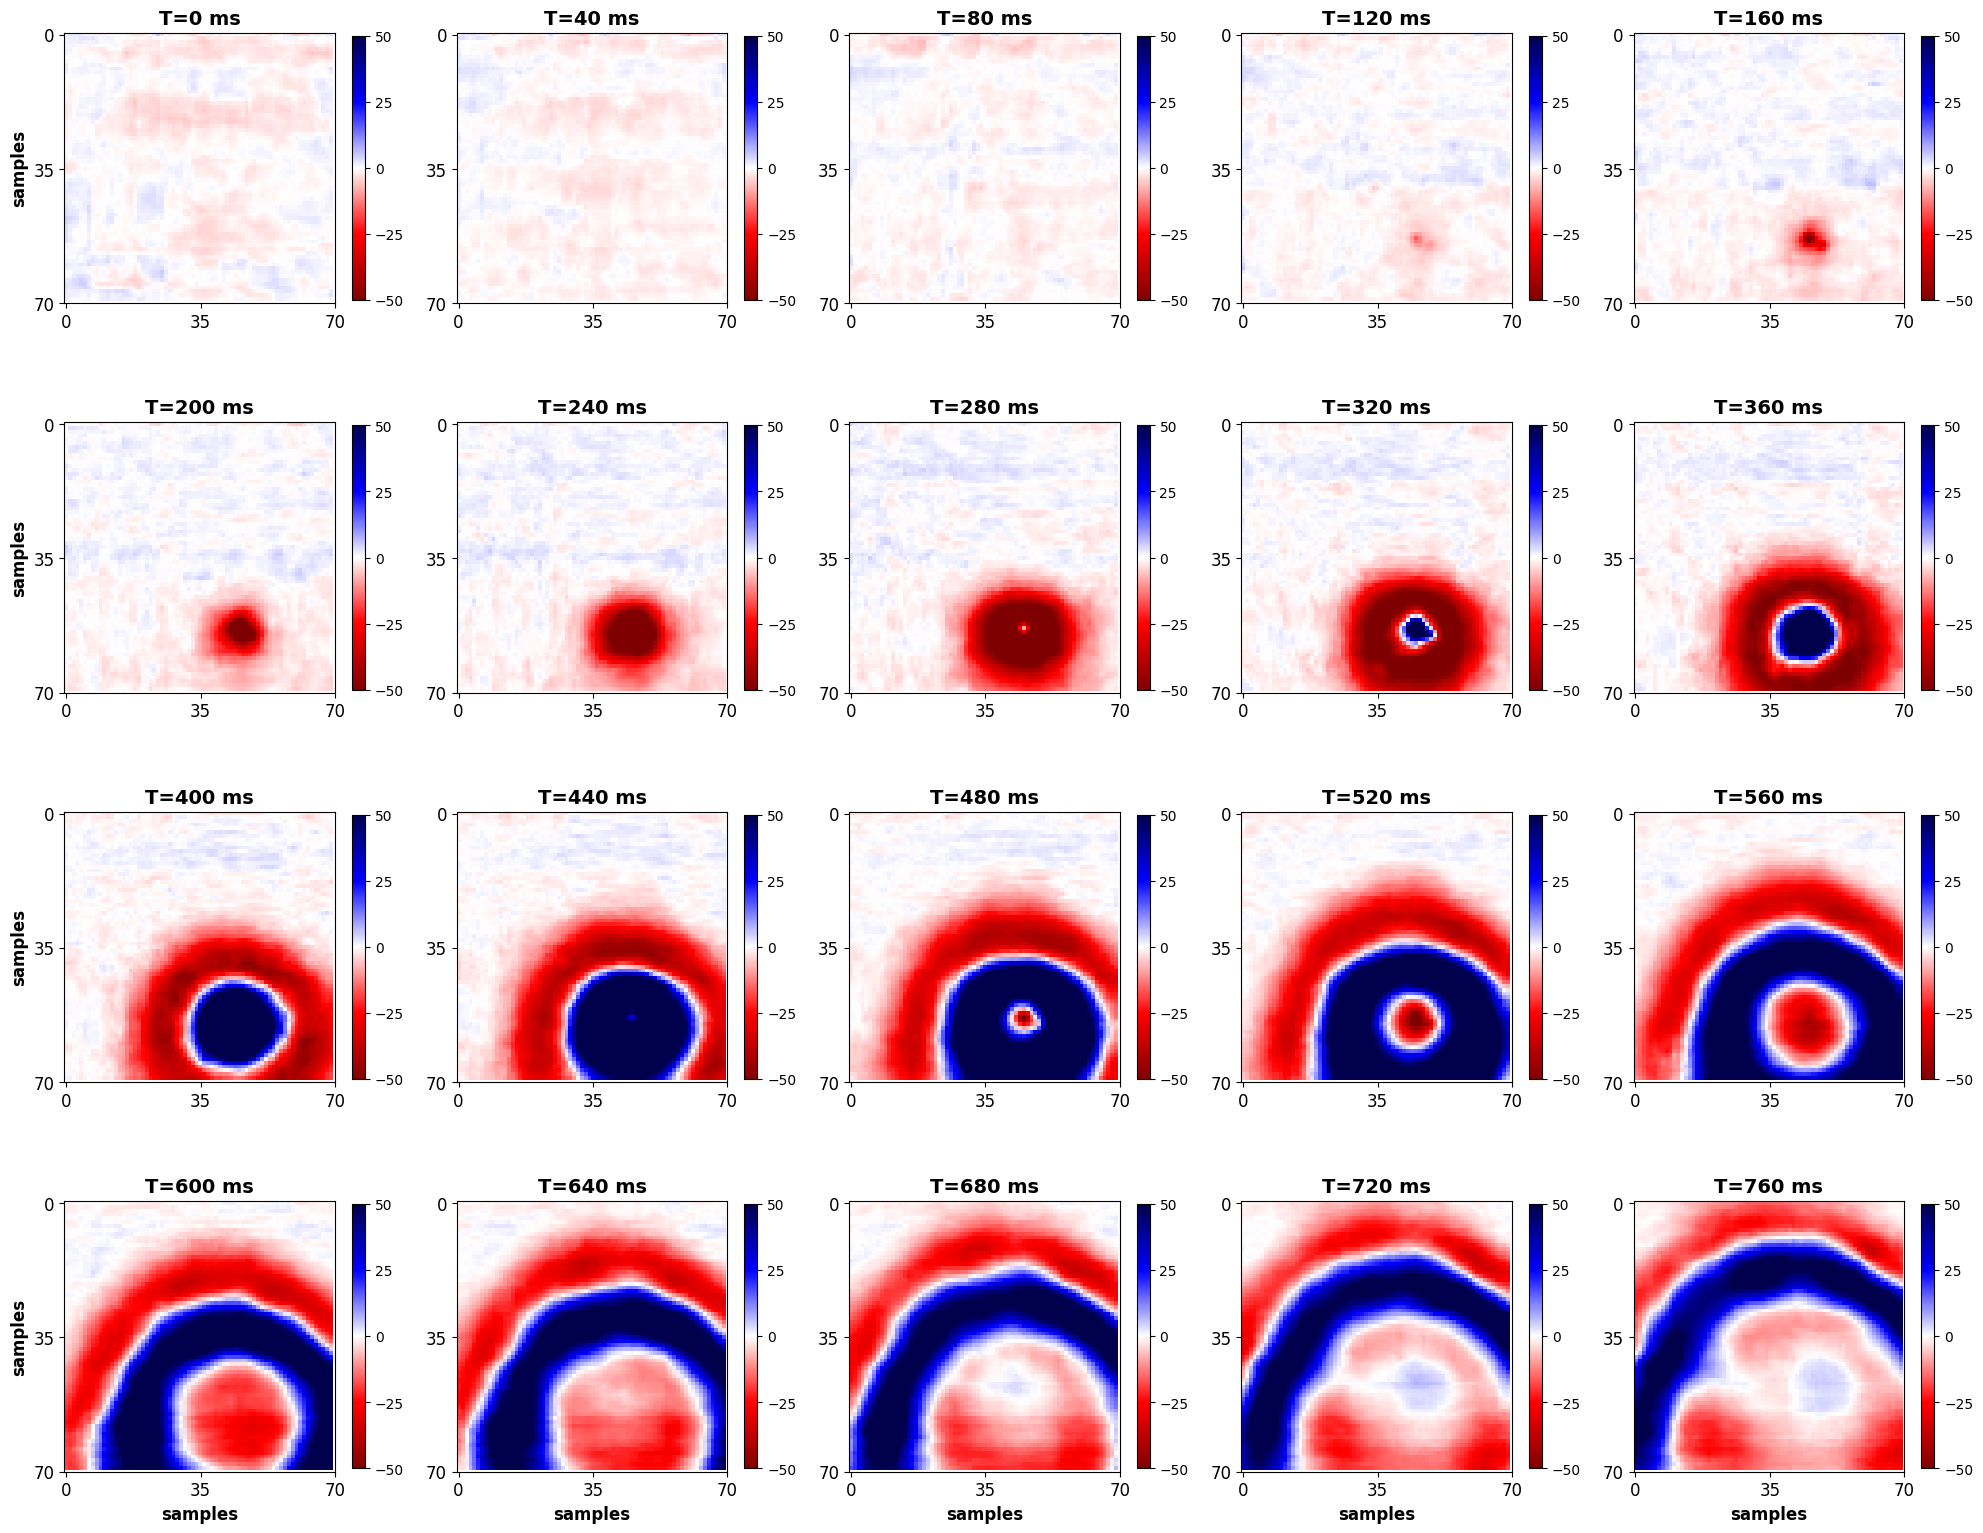

In [12]:
n = 3
imcnt = 1 # Image counter for plotting
plot_num = 20 # Number of images to plot e.g., 2, 4, 6, ...
v = 50
num_rows = 4
num_cols = plot_num // 4
nsnaps = 100
time_interval = 8


# Determine the spacing between slices along the first channel
slice_spacing = nsnaps // plot_num

# Plot the slices
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 16))

for i in range(num_rows):
    for j in range(num_cols):
        slice_index = i * num_cols + j
        slice_data = (pre_data[n, :, :, :])[ :, :, slice_index * slice_spacing]

        # Plot the 2D slice on the current subplot
        im = axes[i, j].imshow(slice_data.T, vmin=-v, vmax=v, cmap="seismic_r")
        axes[i, j].set_title(f'T={slice_index * slice_spacing * time_interval} ms', fontsize=14, fontweight='bold')
        axes[i, j].set_xticks([0, slice_data.shape[0]/2, slice_data.shape[0]])
        axes[i, j].set_yticks([0, slice_data.shape[0]/2, slice_data.shape[0]])
        axes[i, j].tick_params(axis='x', labelsize=12)  # Adjust the fontsize for the x ticks
        axes[i, j].tick_params(axis='y', labelsize=12)  # Adjust the fontsize for the y ticks
#         axes[i, j].colorbar(shrink=0.54)
        # Set y-label for the first column
        if j == 0:
            axes[i, j].set_ylabel('samples', fontsize=12, fontweight='bold')

        # Set x-label for the last row
        if i == num_rows - 1:
            axes[i, j].set_xlabel('samples', fontsize=12, fontweight='bold')
        cbar = fig.colorbar(im, ax=axes[i, j], shrink=0.7)
        cbar.ax.tick_params(labelsize=10)
        cbar.set_ticks([-v, -v/2, 0, v/2, v])
plt.tight_layout()
# plt.savefig(f'./figs/modified/train_data/Train_num_{n}_epoch_{epochs}_width_{width}_fre_{freq}Hz.pdf', bbox_inches="tight", dpi=300)
# plt.savefig(f'./figs/modified/train_data/Train_num_{n}_epoch_{epochs}_width_{width}_fre_{freq}Hz.png', bbox_inches="tight", dpi=300)
plt.show()

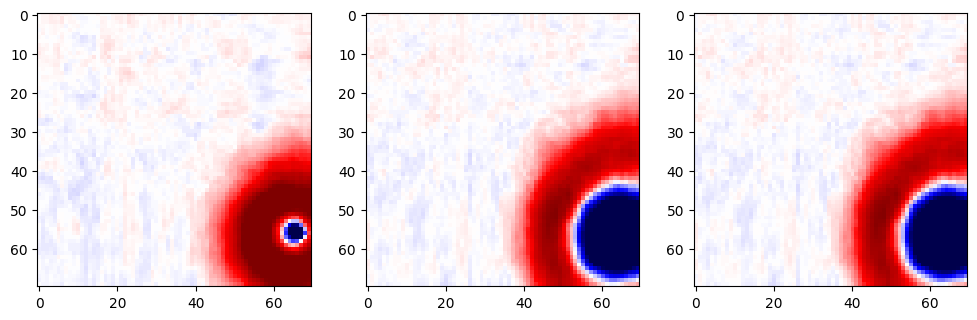

(10, 70, 70, 100)


In [13]:
n = 2
clip=60
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(pre_data[n, :, :, 39], aspect='1', cmap ='seismic_r', vmin = -clip, vmax =clip)

plt.subplot(132)
plt.imshow(pre_data[n, :, :, 49], aspect='1', cmap ='seismic_r', vmin = -clip, vmax =clip)

plt.subplot(133)
plt.imshow(pre_data[n, :, :, 49], aspect='1', cmap ='seismic_r', vmin = -clip, vmax =clip)
plt.savefig(f'./figs/modified_fno_acoustic_predict_smaple_{ntrain}_e{epochs}_smaple{n}_slice{40_50_60}.png', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/modified_fno_acoustic_predict_smaple_{ntrain}_e{epochs}_smaple{n}_slice{40_50_60}.pdf', bbox_inches="tight", dpi=300)
plt.show()
print(pre_data.shape)

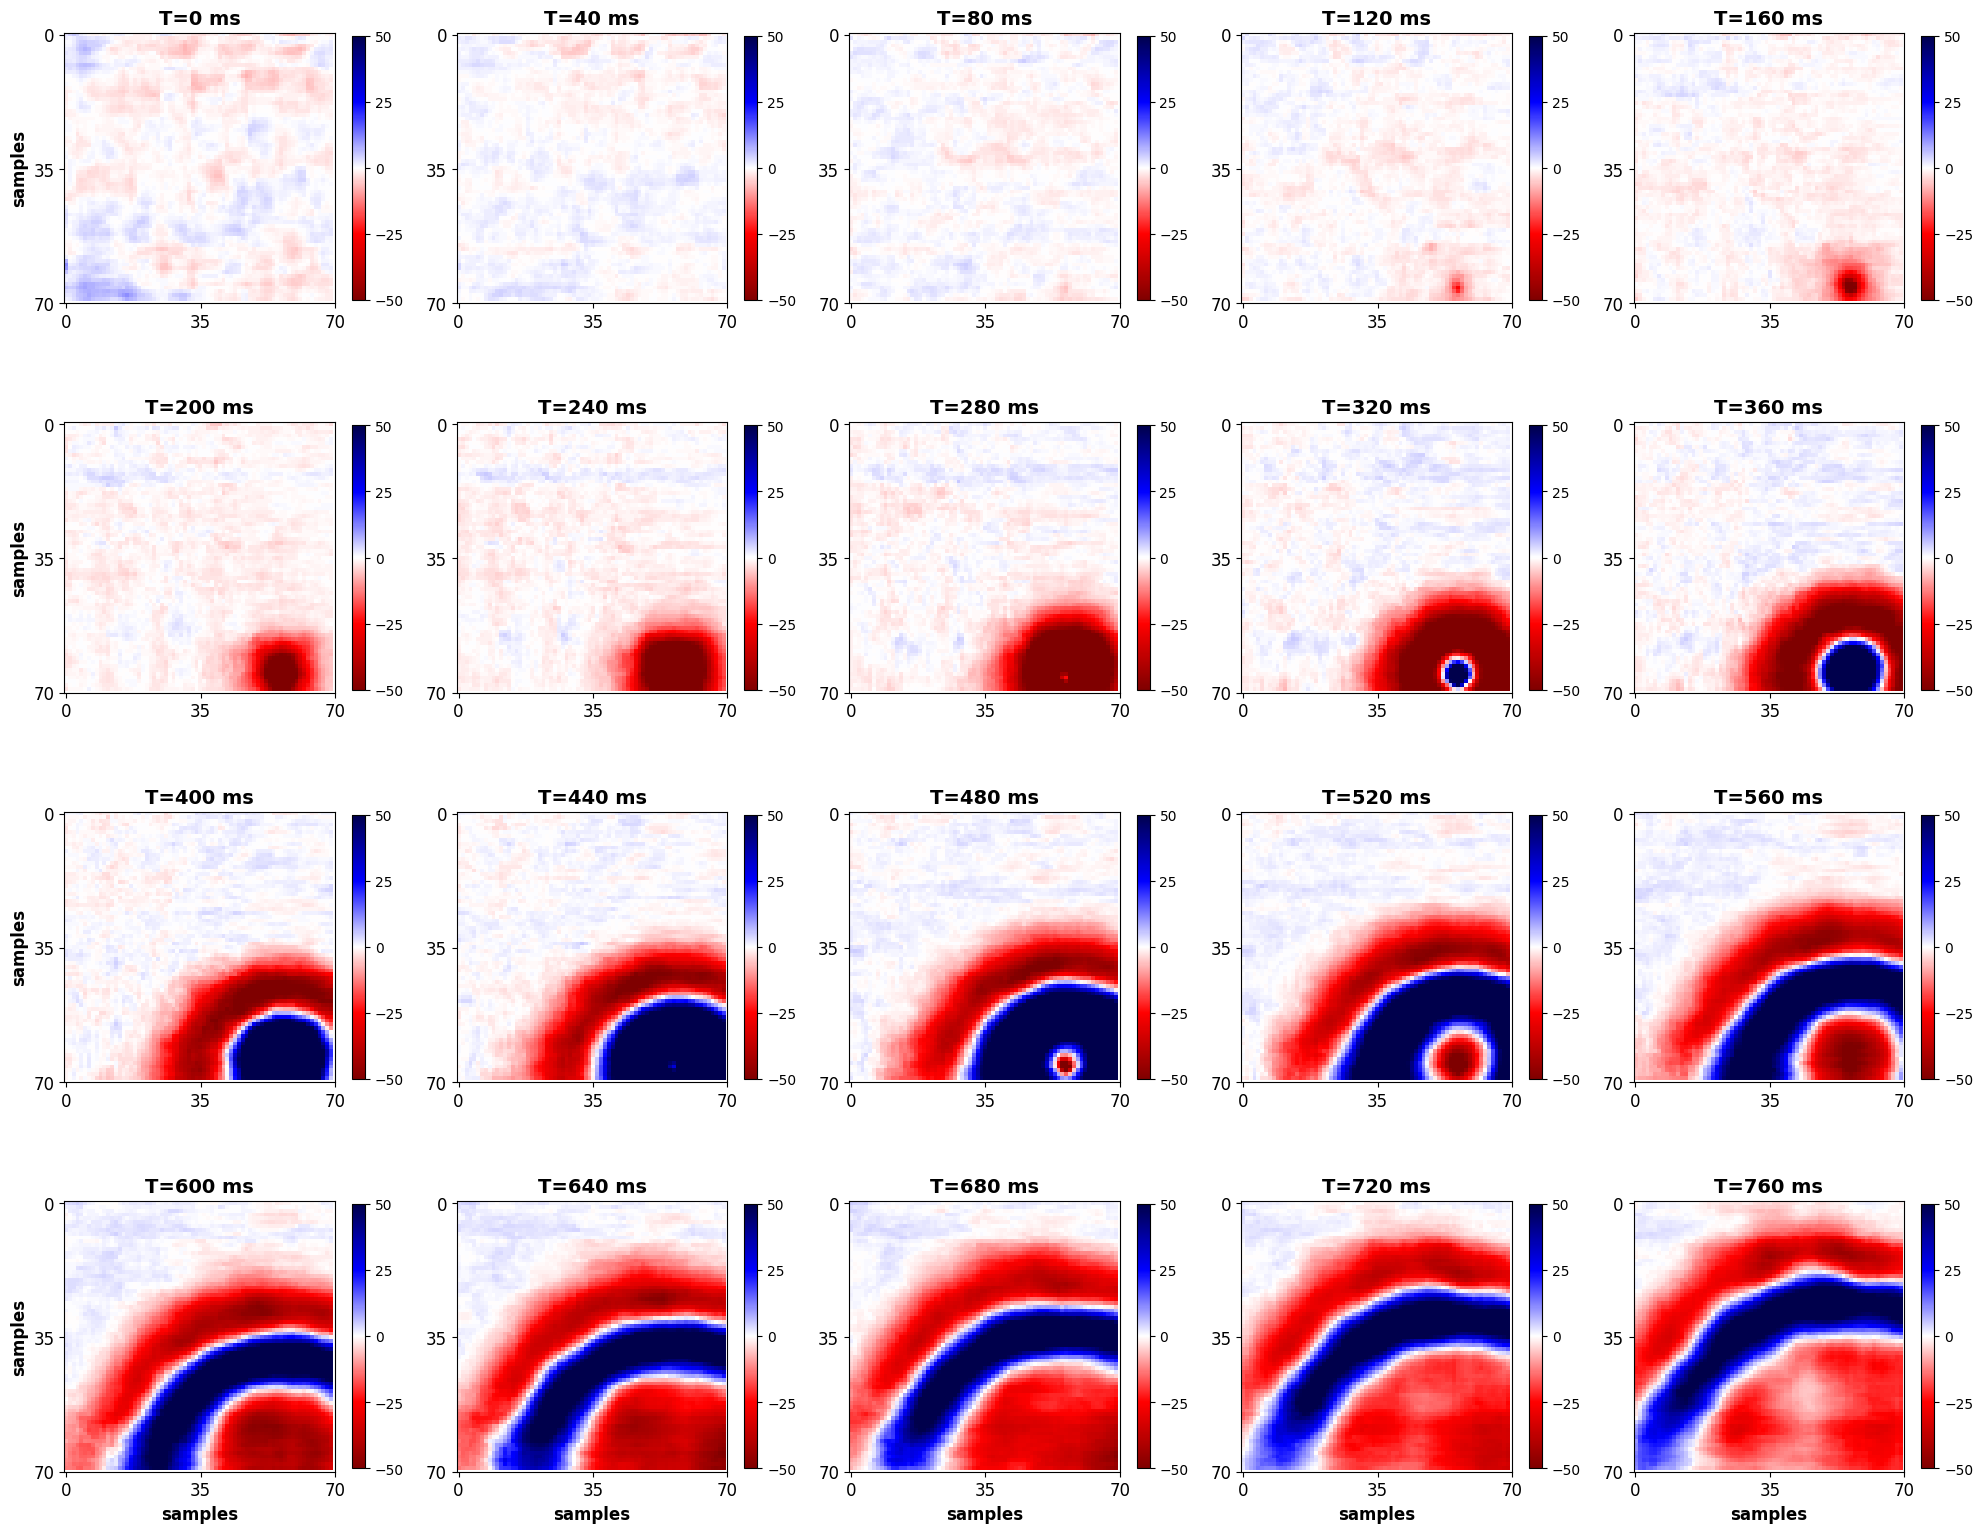

In [14]:
imcnt = 1 # Image counter for plotting
plot_num = 20 # Number of images to plot e.g., 2, 4, 6, ...
v = 50
num_rows = 4
num_cols = plot_num // 4
nsnaps = 100
time_interval = 8


# Determine the spacing between slices along the first channel
slice_spacing = nsnaps // plot_num

# Plot the slices
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 16))

for i in range(num_rows):
    for j in range(num_cols):
        slice_index = i * num_cols + j
        slice_data = (pre_data[n, :, :, :])[ :, :, slice_index * slice_spacing]

        # Plot the 2D slice on the current subplot
        im = axes[i, j].imshow(slice_data.T, vmin=-v, vmax=v, cmap="seismic_r")
        axes[i, j].set_title(f'T={slice_index * slice_spacing * time_interval} ms', fontsize=14, fontweight='bold')
        axes[i, j].set_xticks([0, slice_data.shape[0]/2, slice_data.shape[0]])
        axes[i, j].set_yticks([0, slice_data.shape[0]/2, slice_data.shape[0]])
        axes[i, j].tick_params(axis='x', labelsize=12)  # Adjust the fontsize for the x ticks
        axes[i, j].tick_params(axis='y', labelsize=12)  # Adjust the fontsize for the y ticks
#         axes[i, j].colorbar(shrink=0.54)
        # Set y-label for the first column
        if j == 0:
            axes[i, j].set_ylabel('samples', fontsize=12, fontweight='bold')

        # Set x-label for the last row
        if i == num_rows - 1:
            axes[i, j].set_xlabel('samples', fontsize=12, fontweight='bold')
        cbar = fig.colorbar(im, ax=axes[i, j], shrink=0.7)
        cbar.ax.tick_params(labelsize=10)
        cbar.set_ticks([-v, -v/2, 0, v/2, v])
plt.tight_layout()
plt.savefig(f'./figs/modified/test_data/Test_num_{n}_fre_{freq}Hz.pdf', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/modified/test_data/Test_num_{n}_fre_{freq}Hz.png', bbox_inches="tight", dpi=300)
plt.show()

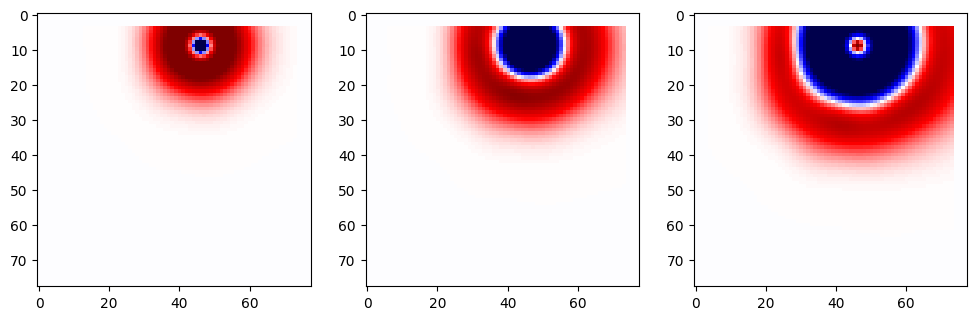

In [15]:
n = 4
clip=60
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(test_u[n, :, :, 39], aspect='1', cmap ='seismic_r', vmin = -clip, vmax =clip)

plt.subplot(132)
plt.imshow(test_u[n, :, :, 49], aspect='1', cmap ='seismic_r', vmin = -clip, vmax =clip)

plt.subplot(133)
plt.imshow(test_u[n, :, :, 59], aspect='1', cmap ='seismic_r', vmin = -clip, vmax =clip)

plt.savefig(f'./figs/modified_fno_acoustic_label_smaple_{ntrain}_e{epochs}_smaple{n}_slice{40_50_60}.png', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/modified_fno_acoustic_label_smaple_{ntrain}_e{epochs}_smaple{n}_slice{40_50_60}.pdf', bbox_inches="tight", dpi=300)
plt.show()


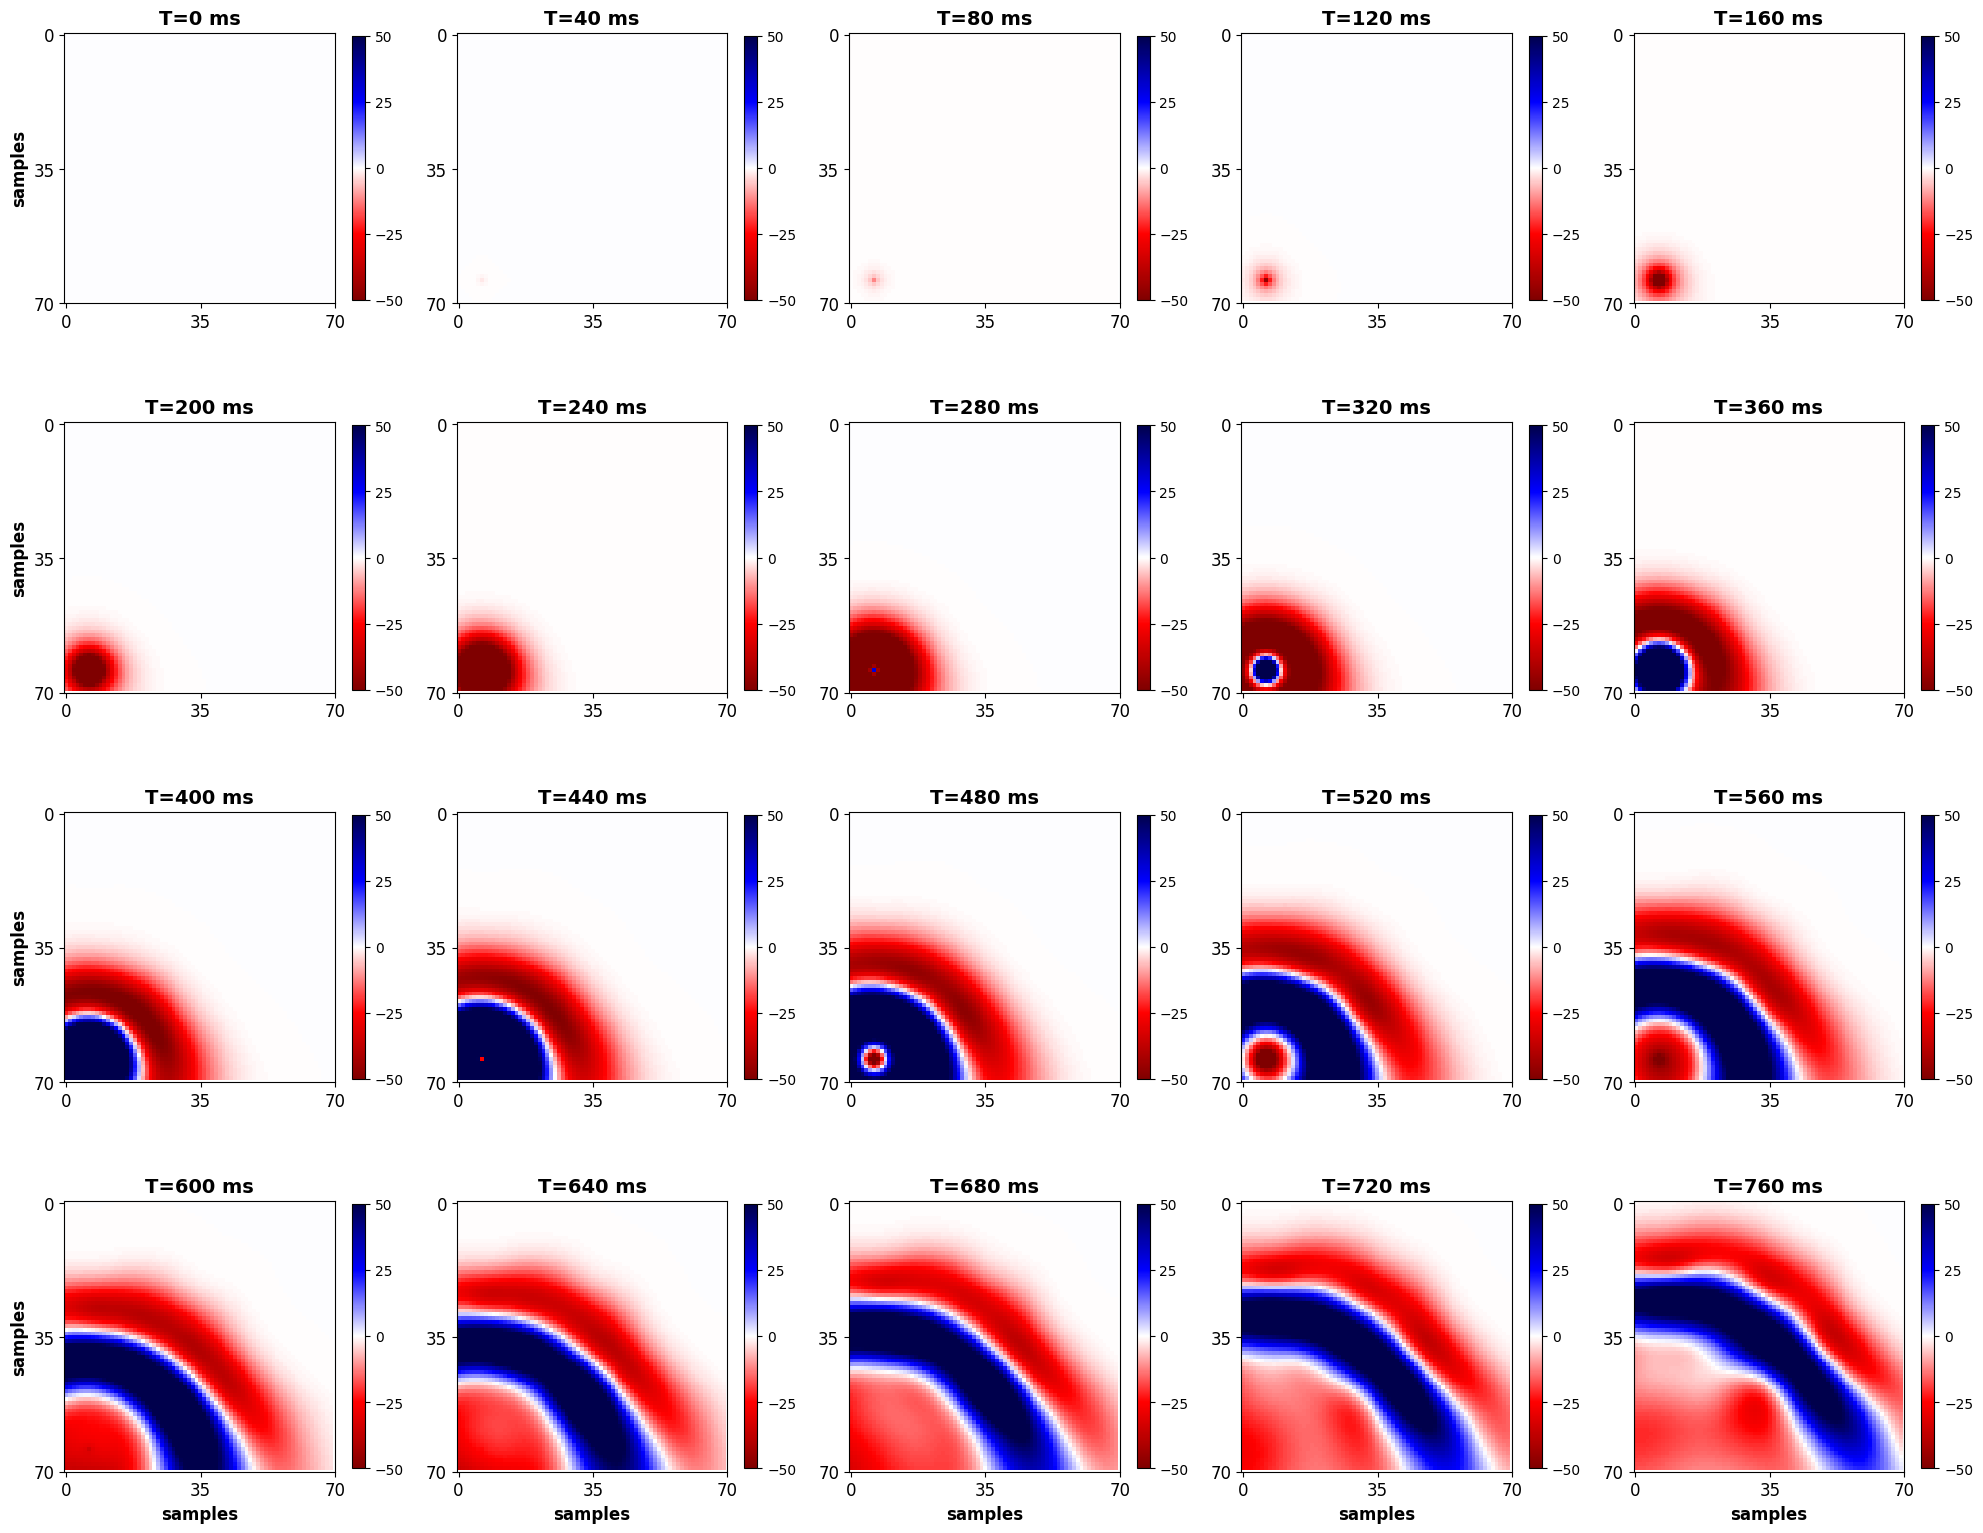

In [16]:
n = 0
imcnt = 1 # Image counter for plotting
plot_num = 20 # Number of images to plot e.g., 2, 4, 6, ...
v = 50
num_rows = 4
num_cols = plot_num // 4
nsnaps = 100
time_interval = 8

test_u = test_u[:,S_pad:-S_pad,S_pad:-S_pad,:]
# Determine the spacing between slices along the first channel
slice_spacing = nsnaps // plot_num

# Plot the slices
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 16))

for i in range(num_rows):
    for j in range(num_cols):
        slice_index = i * num_cols + j
        slice_data = (test_u[n, :, :, :])[ :, :, slice_index * slice_spacing]

        # Plot the 2D slice on the current subplot
        im = axes[i, j].imshow(slice_data.T, vmin=-v, vmax=v, cmap="seismic_r")
        axes[i, j].set_title(f'T={slice_index * slice_spacing * time_interval} ms', fontsize=14, fontweight='bold')
        axes[i, j].set_xticks([0, slice_data.shape[0]/2, slice_data.shape[0]])
        axes[i, j].set_yticks([0, slice_data.shape[0]/2, slice_data.shape[0]])
        axes[i, j].tick_params(axis='x', labelsize=12)  # Adjust the fontsize for the x ticks
        axes[i, j].tick_params(axis='y', labelsize=12)  # Adjust the fontsize for the y ticks
#         axes[i, j].colorbar(shrink=0.54)
        # Set y-label for the first column
        if j == 0:
            axes[i, j].set_ylabel('samples', fontsize=12, fontweight='bold')

        # Set x-label for the last row
        if i == num_rows - 1:
            axes[i, j].set_xlabel('samples', fontsize=12, fontweight='bold')
        cbar = fig.colorbar(im, ax=axes[i, j], shrink=0.7)
        cbar.ax.tick_params(labelsize=10)
        cbar.set_ticks([-v, -v/2, 0, v/2, v])
plt.tight_layout()
plt.savefig(f'./figs/modified/test_data/Test_label_num_{n}_epoch_{epochs}_width_{width}_10Hz.pdf', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/modified/test_data/Test_label_num_{n}_epoch_{epochs}_width_{width}_10Hz.png', bbox_inches="tight", dpi=300)
plt.show()

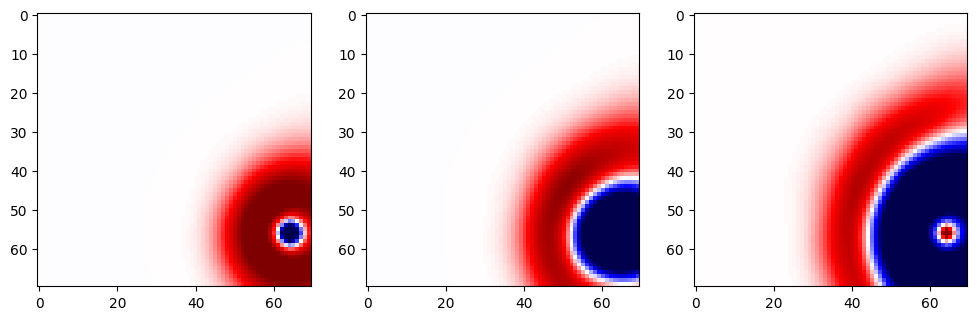

In [17]:
n = 2
clip=60
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(test_u[n, :, :, 39], aspect='1', cmap ='seismic_r', vmin = -clip, vmax =clip)

plt.subplot(132)
plt.imshow(test_u[n, :, :, 49], aspect='1', cmap ='seismic_r', vmin = -clip, vmax =clip)

plt.subplot(133)
plt.imshow(test_u[n, :, :, 59], aspect='1', cmap ='seismic_r', vmin = -clip, vmax =clip)

plt.savefig(f'./figs/modified_fno_acoustic_train_smaple_{ntrain}_e{epochs}_smaple{n}_slice{40_50_60}.png', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/modified_fno_acoustic_train_smaple_{ntrain}_e{epochs}_smaple{n}_slice{40_50_60}.pdf', bbox_inches="tight", dpi=300)
plt.show()


In [18]:
vel = np.load('./input_a/dV.npy')
print(vel.shape)

(100, 64, 64)


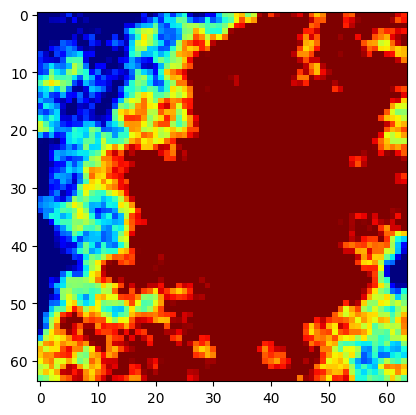

In [19]:
clip = 5
xx = 10
plt.figure()
plt.imshow(vel[xx, :, :], aspect='1', cmap ='jet', vmin = -clip, vmax =clip)

plt.savefig(f'./figs/velmodel/velmodel_{ntrain}_e{epochs}_smaple{xx+1}_slice{40_50_60}.png', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/velmodel/velmodel_{ntrain}_e{epochs}_smaple{xx+1}_slice{40_50_60}.pdf', bbox_inches="tight", dpi=300)
plt.show()

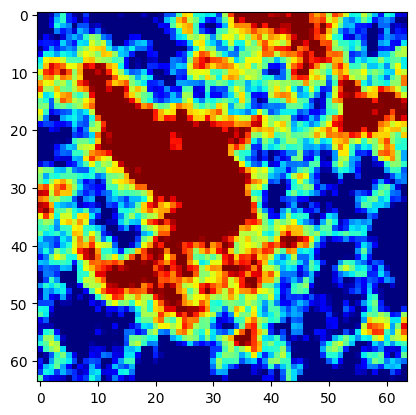

In [20]:
clip = 5
xx = 50
plt.figure()
plt.imshow(vel[xx, :, :], aspect='1', cmap ='jet', vmin = -clip, vmax =clip)

plt.savefig(f'./figs/velmodel/velmodel_{ntrain}_e{epochs}_smaple{xx+1}_slice{40_50_60}.png', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/velmodel/velmodel_{ntrain}_e{epochs}_smaple{xx+1}_slice{40_50_60}.pdf', bbox_inches="tight", dpi=300)
plt.show()

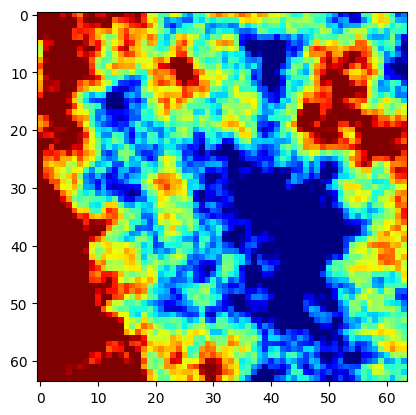

In [21]:
clip = 5
xx = 80
plt.figure()
plt.imshow(vel[xx, :, :], aspect='1', cmap ='jet', vmin = -clip, vmax =clip)

plt.savefig(f'./figs/velmodel/velmodel_{ntrain}_e{epochs}_smaple{xx+1}_slice{40_50_60}.png', bbox_inches="tight", dpi=300)
plt.savefig(f'./figs/velmodel/velmodel_{ntrain}_e{epochs}_smaple{xx+1}_slice{40_50_60}.pdf', bbox_inches="tight", dpi=300)
plt.show()